In [1]:
!nvidia-smi

Fri Aug  9 07:14:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   57C    P8              13W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Installing SAM2 from github repo


In [3]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 440, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 440 (delta 87), reused 54 (delta 43), pack-reused 306
Receiving objects: 100% (440/440), 68.37 MiB | 15.98 MiB/s, done.
Resolving deltas: 100% (101/101), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 24.6 kB/s eta 0:00:00
  Building 

## Requirements

In [4]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 27.5 MB/s eta 0:00:00


## Loading preloaded checkpoints

In [5]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

## Adding Sample Data

In [6]:
!mkdir -p {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data
!wget -q https://www.rappler.com/tachyon/2023/06/edsa-traffic-june-14-2023-604.jpg -P {HOME}/data

In [7]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

## Setting up device

In [8]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"  # <----------------------------------------------------IMAGE PATH CHANGE HERE-------------------------------

CONFIG = "sam2_hiera_l.yaml"

In [10]:
sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

In [11]:
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

In [46]:
IMAGE_PATH = f"{HOME}/data/sheep1.webp"    # <----------------------------------------------------IMAGE PATH CHANGE HERE-------------------------------

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam2_result = mask_generator.generate(image_rgb)

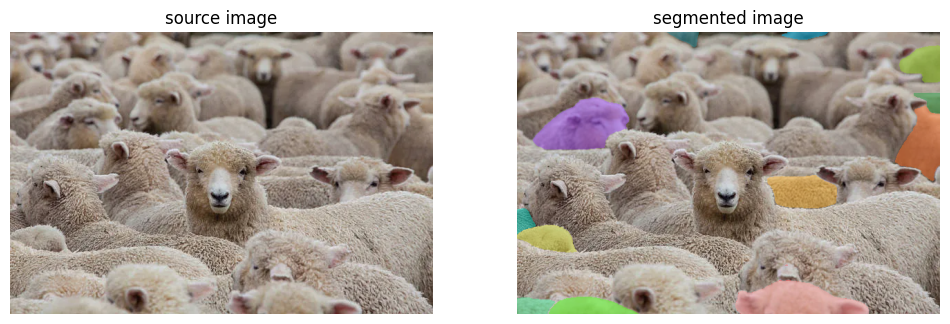

In [47]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

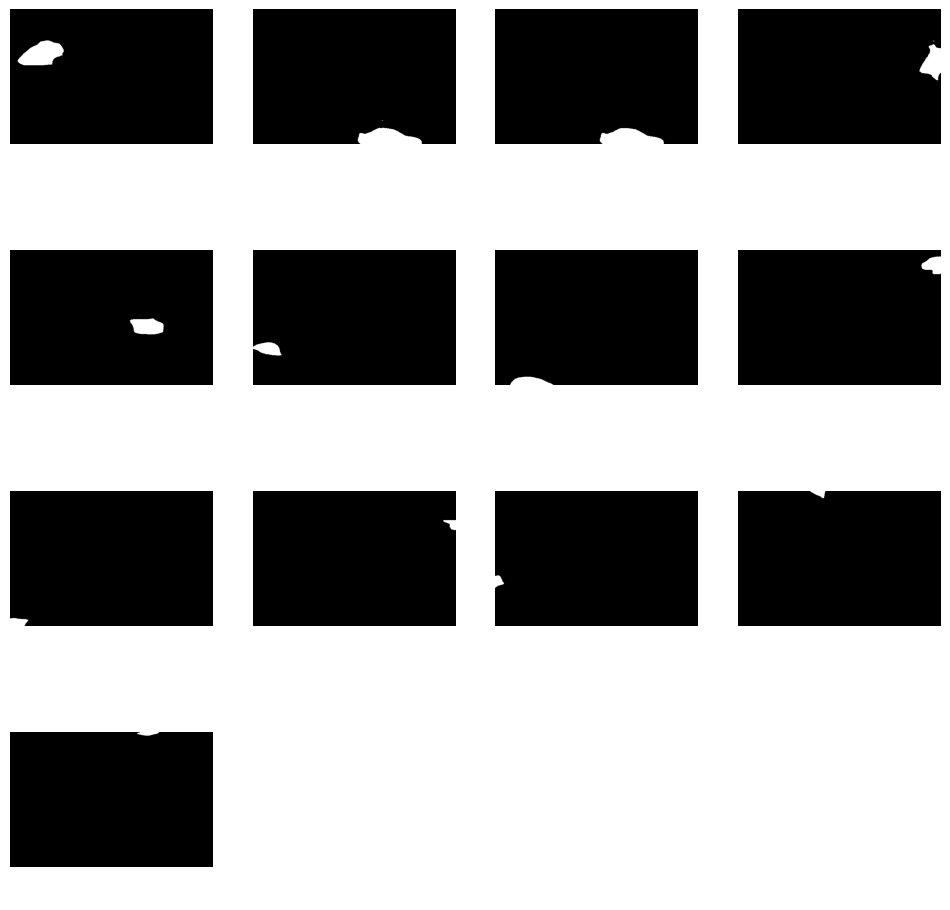

In [48]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam2_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks[:16],
    grid_size=(4, 4),
    size=(12, 12)
)

In [15]:
# import torch
# torch.cuda.empty_cache()

In [57]:
# UPDATING PARAMETERS


mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=100,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=2,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
    box_nms_thresh=0.8,
)

In [17]:
# mask_generator_2.to('cpu')
# image_rgb = image_rgb.to('cpu')

In [58]:
sam2_result_2 = mask_generator_2.generate(image_rgb)


Skipping the post-processing step due to the error above. Consider building SAM 2 with CUDA extension to enable post-processing (see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).


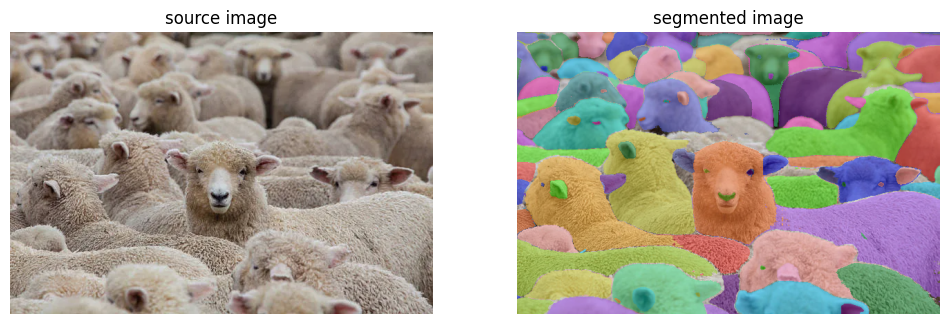

In [59]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result_2)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

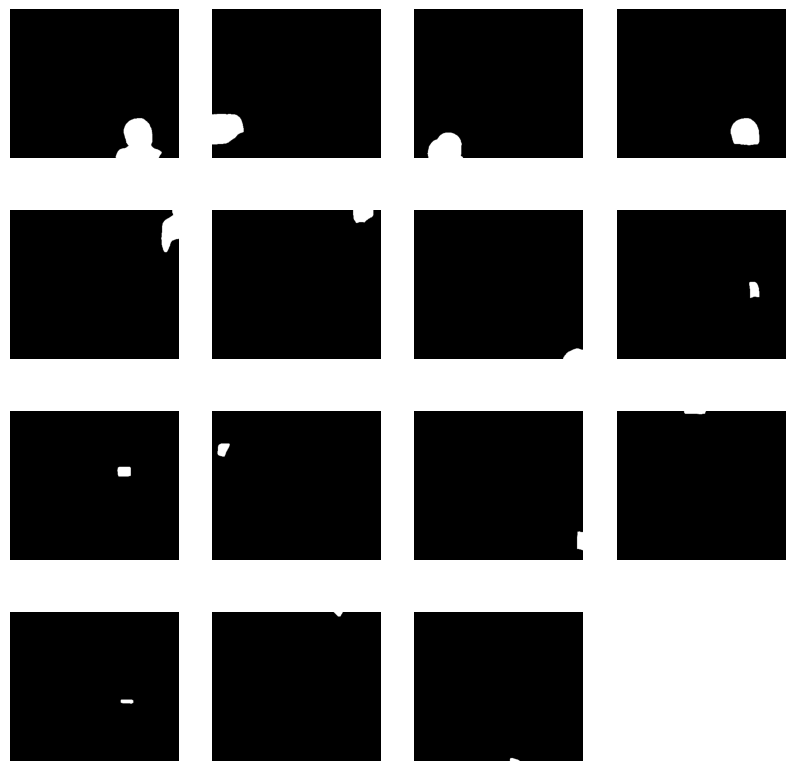

In [43]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam2_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks[:16],
    grid_size=(4, 4),
    size=(10, 10)
)

# Prompting

In [21]:
predictor = SAM2ImagePredictor(sam2_model)

In [22]:
IMAGE_PATH = f"{HOME}/data/people/compresesppl1.jpg"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

In [ ]:
widget.bboxes

In [ ]:
default_box = [
    {'x': 166, 'y': 835, 'width': 99, 'height': 175, 'label': ''},
    {'x': 472, 'y': 885, 'width': 168, 'height': 249, 'label': ''},
    {'x': 359, 'y': 727, 'width': 27, 'height': 155, 'label': ''},
    {'x': 164, 'y': 1044, 'width': 279, 'height': 163, 'label': ''}
]

boxes = widget.bboxes if widget.bboxes else default_box
boxes = np.array([
    [
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ] for box in boxes
])

# NOTE: Sam2ImagePredictor.predict method takes np.ndarray box argument in [x_min, y_min, x_max, y_max] format.

In [ ]:
predictor.set_image(image_rgb)

masks, scores, logits = predictor.predict(
    box=boxes,
    multimask_output=False
)

masks = np.squeeze(masks)

In [ ]:
box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks.astype(bool)
)

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

In [ ]:
widget.bboxes

In [ ]:
default_box = [
    {'x': 330, 'y': 450, 'width': 0, 'height': 0, 'label': ''},
    {'x': 191, 'y': 665, 'width': 0, 'height': 0, 'label': ''},
    {'x': 86, 'y': 879, 'width': 0, 'height': 0, 'label': ''},
    {'x': 425, 'y': 727, 'width': 0, 'height': 0, 'label': ''}
]

boxes = widget.bboxes if widget.bboxes else default_box
input_point = np.array([
    [
        box['x'],
        box['y']
    ] for box in boxes
])
input_label = np.ones(input_point.shape[0])

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [ ]:
sv.plot_images_grid(
    images=masks,
    titles=[f"score: {score:.2f}" for score in scores],
    grid_size=(1, 3),
    size=(12, 12)
)